In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockdata/MSFT-1.csv


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv("/kaggle/input/stockdata/MSFT-1.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


In [4]:
data.drop('Adj Close', axis = 1, inplace = True)
data['Date'] = pd.to_datetime(data.Date,format='%m/%d/%Y')
data.index = data['Date']
data.drop('Date', axis = 1, inplace = True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [5]:
data.describe()

,Open,High,Low,Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,146.287824,147.655520,144.880643,146.367093,2.847798e+07
std,70.320089,70.991915,69.717498,70.436664,1.275474e+07
min,58.230000,59.080002,57.279999,58.119999,7.425600e+06
25%,90.479999,92.029999,89.340000,90.500000,2.027270e+07
50%,125.790001,126.709999,124.739998,126.019997,2.520130e+07
75%,207.175003,209.684998,203.699997,206.224998,3.272640e+07
max,338.510010,338.790009,334.420013,336.440002,1.112421e+08


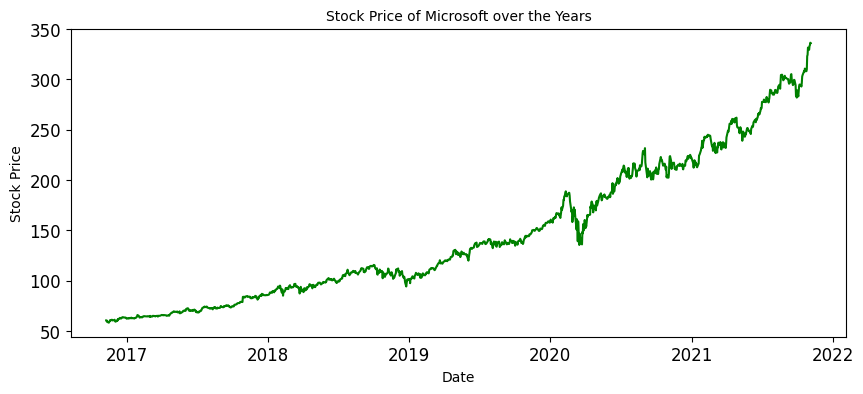

In [6]:
plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=10)
plt.ylabel('Stock Price',size=10)
plt.title('Stock Price of Microsoft over the Years',size=10)
plt.show()

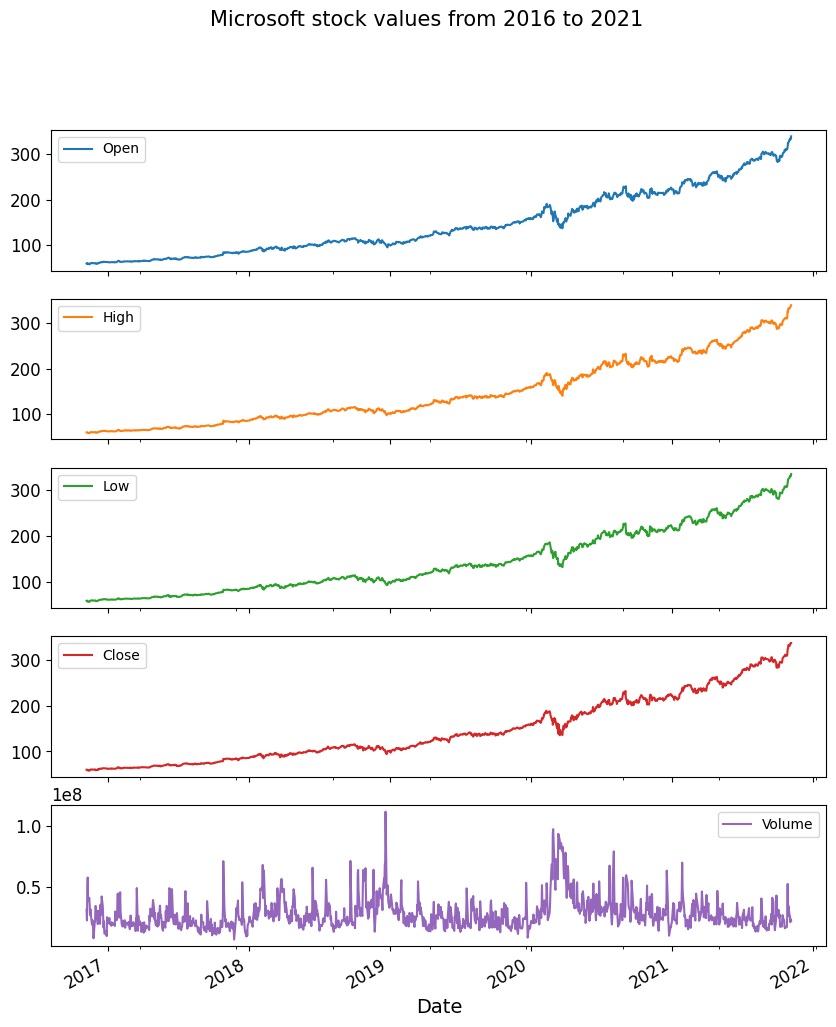

In [7]:
data.plot(subplots=True, figsize=(10,12))
plt.suptitle('Microsoft stock values from 2016 to 2021',fontsize=15)
plt.show()

In [11]:
def train_test(data):
    print("Splitting the data into train and test\n")
    train_size = int(len(data) * 0.80)
    train, test = data[0:train_size], data[train_size:len(data)]
    return train, test

In [13]:
train, test = train_test(data)

Splitting the data into train and test



In [14]:
print(train)
print(test)

                  Open        High         Low       Close    Volume
Date                                                                
2016-11-07   59.779999   60.520000   59.779999   60.419998  31664800
2016-11-08   60.549999   60.779999   60.150002   60.470001  22935400
2016-11-09   60.000000   60.590000   59.200001   60.169998  49632500
2016-11-10   60.480000   60.490002   57.630001   58.700001  57822400
2016-11-11   58.230000   59.119999   58.009998   59.020000  38767800
...                ...         ...         ...         ...       ...
2020-10-30  203.500000  204.289993  199.619995  202.470001  36953700
2020-11-02  204.289993  205.279999  200.119995  202.330002  30842200
2020-11-03  203.889999  208.119995  203.119995  206.429993  27512000
2020-11-04  214.020004  218.320007  212.419998  216.389999  42311800
2020-11-05  222.039993  224.119995  221.149994  223.289993  36080100

[1007 rows x 5 columns]
                  Open        High         Low       Close    Volume
Date     

In [15]:
# defining the number of timesteps and features
timestep = 60
features = 5

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train)
test_df = scaler.transform(test)

In [20]:
print(train_df)
print(test_df)

[[0.0090622  0.00828633 0.01469983 0.01325419 0.23348119]
 [0.01356407 0.00978247 0.01687542 0.01354234 0.14939629]
 [0.01034846 0.00868914 0.01128948 0.01181351 0.40655291]
 ...
 [0.85161363 0.85763606 0.85752919 0.85466489 0.19347984]
 [0.91083957 0.91633103 0.91221257 0.91206134 0.33603714]
 [0.95772912 0.94970649 0.96354435 0.95182388 0.27601104]]
[[0.95901538 0.95108758 0.945199   0.95430189 0.17151705]
 [0.97176098 0.9727241  0.94431704 0.92358673 0.35610332]
 [0.91364591 0.90585798 0.89633678 0.88105803 0.35273295]
 ...
 [1.61172818 1.58717916 1.60739686 1.58981161 0.13557094]
 [1.60582325 1.59661646 1.60069383 1.60387259 0.15957579]
 [1.63868103 1.60956387 1.62956431 1.60168275 0.14581882]]


**Use 60 days data to predict next 1 day**

In [21]:
def create_sequences(data,timesteps):
    x = []
    y = []
    for i in range(timesteps,len(data)):
        x.append(data[i-timesteps:i,:])
        y.append(data[i,0:5])
        
    x = np.array(x)
    y = np.array(y)
    return x,y

In [22]:
x_train,y_train = create_sequences(train_df,timestep)
x_test,y_test = create_sequences(test_df,timestep)

In [23]:
# checking train and test data shape
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(947, 60, 5)
(192, 60, 5)
(947, 5)
(192, 5)


**Building LSTM Model**

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(timestep,features)))
model1.add(LSTM(units=50))
model1.add(Dense(features))

model1.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
history1 = model1.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/20
30/30 [==============================] - 5s 35ms/step - loss: 0.0329 - val_loss: 0.0646
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0368
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0299
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0340
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0231
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0249
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0249
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0241
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0196
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0184
Epoch 11/20
30/30

In [71]:
y_pred = model1.predict(x_test)

6/6 [==============================] - 1s 4ms/step


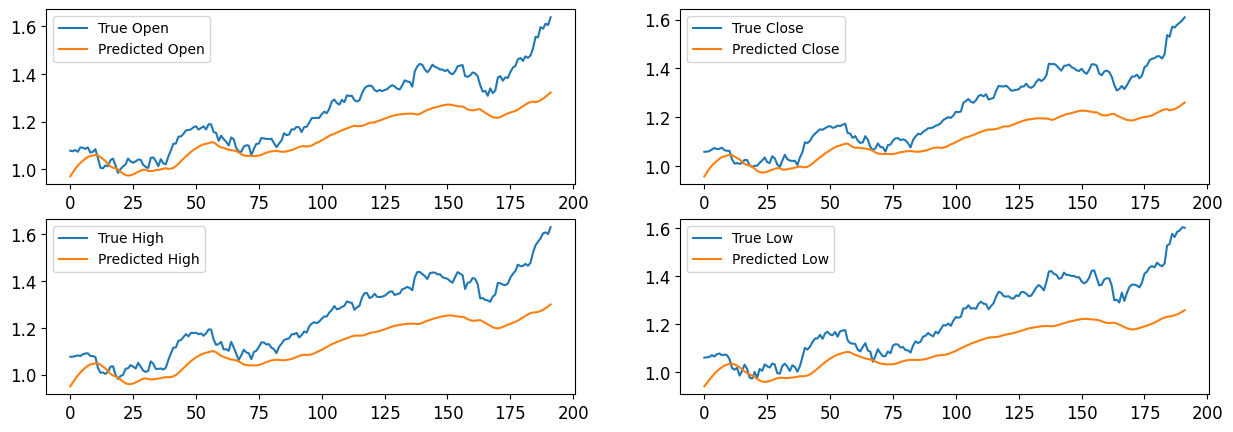

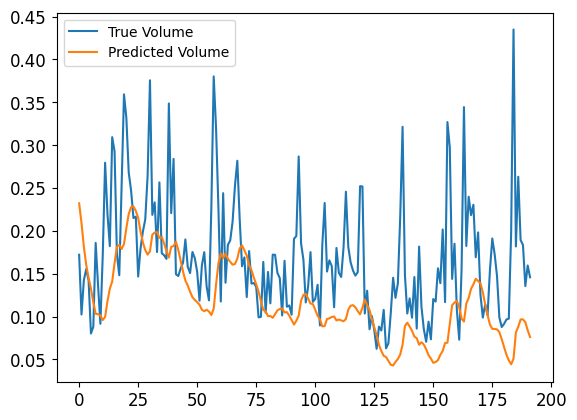

In [72]:
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.plot(y_test[:,0], label='True Open')
plt.plot(y_pred[:,0], label='Predicted Open')
plt.legend()
plt.subplot(2,2,2)
plt.plot(y_test[:,1], label='True Close')
plt.plot(y_pred[:,1], label='Predicted Close')
plt.legend()
plt.subplot(2,2,3)
plt.plot(y_test[:,2], label='True High')
plt.plot(y_pred[:,2], label='Predicted High')
plt.legend()
plt.subplot(2,2,4)
plt.plot(y_test[:,3], label='True Low')
plt.plot(y_pred[:,3], label='Predicted Low')
plt.legend()
plt.show()
plt.figure()
plt.plot(y_test[:,4], label='True Volume')
plt.plot(y_pred[:,4], label='Predicted Volume')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error
model1_mse = mean_squared_error(y_test,y_pred)
print(model1_mse)

0.016232117219530766


In [74]:
y_pred1 = scaler.inverse_transform(y_pred)
y_test1 = scaler.inverse_transform(y_test)

In [75]:
print('RMSE calculated after inverse transformation for LSTM Model : ')
for i in range(features):
    rmse = np.sqrt(np.mean(y_pred1[:,i] - y_test1[:,i])**2)
    print('rmse for {} value is {}'.format(data.columns[i],rmse))

RMSE calculated after inverse transformation for LSTM Model : 
rmse for Open value is 17.392422434005738
rmse for High value is 19.82186125895691
rmse for Low value is 20.146375583607995
rmse for Close value is 21.016515810943606
rmse for Volume value is 5283711.171875


**Building Simple RNN model**

In [39]:
from keras.layers import SimpleRNN
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model2 = Sequential()
model2.add(SimpleRNN(units=64, return_sequences=True, input_shape=(timestep,features)))
model2.add(SimpleRNN(units=64))
model2.add(Dense(features))

model2.compile(loss='mean_squared_error', optimizer='adam')

In [40]:
history2 = model2.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/20
30/30 [==============================] - 6s 106ms/step - loss: 0.0469 - val_loss: 0.1250
Epoch 2/20
30/30 [==============================] - 3s 94ms/step - loss: 0.0056 - val_loss: 0.0552
Epoch 3/20
30/30 [==============================] - 3s 98ms/step - loss: 0.0036 - val_loss: 0.0420
Epoch 4/20
30/30 [==============================] - 3s 95ms/step - loss: 0.0031 - val_loss: 0.0347
Epoch 5/20
30/30 [==============================] - 3s 95ms/step - loss: 0.0027 - val_loss: 0.0357
Epoch 6/20
30/30 [==============================] - 3s 96ms/step - loss: 0.0024 - val_loss: 0.0319
Epoch 7/20
30/30 [==============================] - 3s 95ms/step - loss: 0.0023 - val_loss: 0.0364
Epoch 8/20
30/30 [==============================] - 3s 99ms/step - loss: 0.0024 - val_loss: 0.0313
Epoch 9/20
30/30 [==============================] - 3s 95ms/step - loss: 0.0022 - val_loss: 0.0336
Epoch 10/20
30/30 [==============================] - 3s 97ms/step - loss: 0.0021 - val_loss: 0.0317
Epoch 11

In [42]:
y_pred = model2.predict(x_test)

6/6 [==============================] - 0s 11ms/step


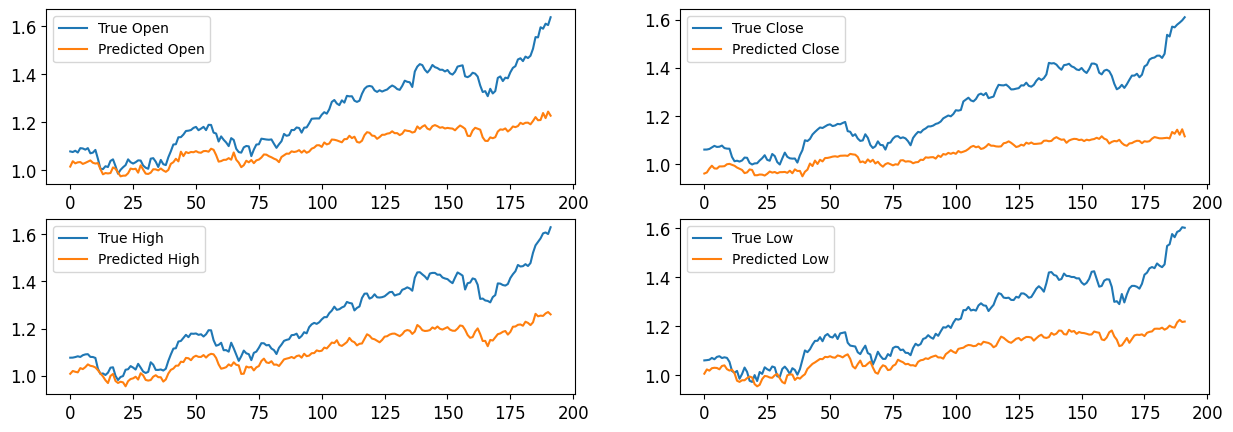

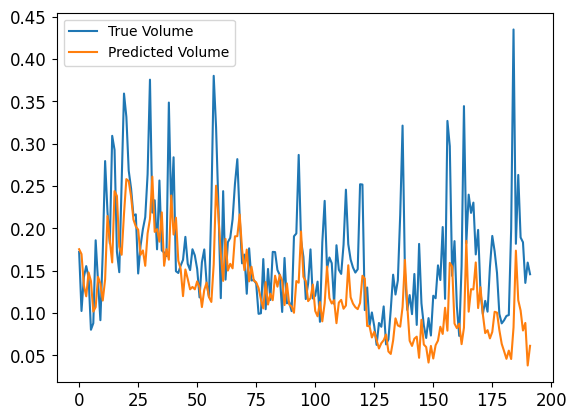

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.plot(y_test[:,0], label='True Open')
plt.plot(y_pred[:,0], label='Predicted Open')
plt.legend()
plt.subplot(2,2,2)
plt.plot(y_test[:,1], label='True Close')
plt.plot(y_pred[:,1], label='Predicted Close')
plt.legend()
plt.subplot(2,2,3)
plt.plot(y_test[:,2], label='True High')
plt.plot(y_pred[:,2], label='Predicted High')
plt.legend()
plt.subplot(2,2,4)
plt.plot(y_test[:,3], label='True Low')
plt.plot(y_pred[:,3], label='Predicted Low')
plt.legend()
plt.show()
plt.figure()
plt.plot(y_test[:,4], label='True Volume')
plt.plot(y_pred[:,4], label='Predicted Volume')
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
model2_mse = mean_squared_error(y_test,y_pred)
print(model2_mse)

0.025651934730557064


In [45]:
y_pred2 = scaler.inverse_transform(y_pred)
y_test2 = scaler.inverse_transform(y_test)

In [47]:
print('RMSE calculated after inverse transformation for LSTM Model : ')
for i in range(features):
    rmse = np.sqrt(np.mean(y_pred2[:,i] - y_test2[:,i])**2)
    print('rmse for {} value is {}'.format(data.columns[i],rmse))

RMSE calculated after inverse transformation for LSTM Model : 
rmse for Open value is 23.91660236946106
rmse for High value is 31.70401031952413
rmse for Low value is 22.52493882874553
rmse for Close value is 22.679888645467127
rmse for Volume value is 4364258.859375


**Model 1 works better, so we will use model 1 to predict the next 2 weeks data**

In [76]:
# latest data
latest_data = test_df[-60:]

In [79]:
predicted_features = []
for i in range(10):
    x = latest_data.reshape(1,timestep,5)
    y = model1.predict(x)
    predicted_features.append(y[0])
    latest_data = np.concatenate([latest_data[1:],y],axis=0)

1/1 [==============================] - 0s 21ms/step


In [86]:
predicted_features_transformed = scaler.inverse_transform(predicted_features)

In [87]:
next_ten_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10, freq='B')
predicted_features_dated = pd.DataFrame(predicted_features_transformed, columns = data.columns)
predicted_features_dated.set_index(next_ten_dates, inplace=True)

In [88]:
predicted_features_dated

,Open,High,Low,Close,Volume
2021-11-08,258.969800,260.736577,254.486066,257.298446,1.374305e+07
2021-11-09,257.411855,259.297174,252.994351,255.846572,1.364440e+07
2021-11-10,255.931185,257.918325,251.580083,254.455371,1.353752e+07
2021-11-11,254.523653,256.598621,250.238740,253.124181,1.342377e+07
2021-11-12,253.185303,255.336135,248.966004,251.851720,1.330449e+07
2021-11-15,251.912016,254.128588,247.757435,250.636022,1.318094e+07
2021-11-16,250.700081,252.973578,246.608957,249.475040,1.305430e+07
2021-11-17,249.545767,251.868618,245.516598,248.366333,1.292563e+07
2021-11-18,248.445751,250.811346,244.476789,247.307521,1.279584e+07
2021-11-19,247.396647,249.799319,243.485962,246.295956,1.266580e+07
